## 0. Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfTransformer
from keras.preprocessing.text import text_to_word_sequence
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

## 1. Prepare data

In [4]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/ML/preprocessing')
import Preprocessor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
X_train, y_train, X_test, y_test = Preprocessor.file_read_vectorizer('/content/drive/MyDrive/ML/data/TrainingSet.csv', '/content/drive/MyDrive/ML/data/TestSet.csv')

## 2. Model training

### 2.1. Default hyperparameter values

In [6]:
import xgboost


xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.8011


In [ ]:
from sklearn.model_selection import GridSearchCV

s_time = time.time()

param_grid = [{'gamma': [0, 0.1, 0.3, 1.0]}]

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

print(f"Total time: {time.time() - s_time}")

{'gamma': 1.0}
Total time: 6841.7548813819885


In [7]:
import time
start = time.time()

xgb = XGBClassifier(learning_rate=0.3, gamma=1.0, random_state=0)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

end = time.time()
print("XGBoost accuracy:", accuracy_score(y_test, y_pred))
print(f"Total time: {end-start}")


0.8381
Total time: 343.06132984161377


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


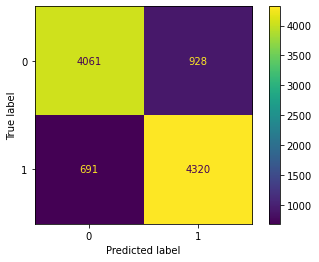

In [8]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb, X_test, y_test)  
plt.show()

In [12]:
start = time.time()

xgb_sk = GradientBoostingClassifier(learning_rate=.3, random_state=0)
xgb_sk.fit(X_train, y_train)

end = time.time()
print("Sklearn XGBoost accuracy: ", accuracy_score(y_test, xgb_sk.predict(X_test)))
print(f"Total time:  {end-start}")

Sklearn XGBoost accuracy:  0.8361
Total time:  1008.0944566726685


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


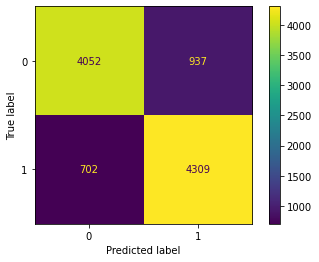

In [13]:
plot_confusion_matrix(xgb_sk, X_test, y_test)  
plt.show()

Comment: The XGBoost Classifier module provided by Sklearn has a higher running time, with a relatively lower accuracy. Thus we might use the XGBoost module from `xgboost` library.